# Welcome to the OnSSET Notebook - Calibration

This Jupyter based interface is built on the [OnSSET](http://www.onsset.org/) tool developed to provide an easy and quick way to create the calibrated input file.

#### Start by importing the code 

In [5]:
from onsset import *
from IPython.display import display, Markdown, HTML
%matplotlib inline
%run funcs.ipynb
import warnings
warnings.filterwarnings('ignore')

In [6]:
import matplotlib.pylab as plt
import seaborn as sns

# 1. GIS data selection

First, run the cell below to browse to the directory your input CSV file is located at and select the input file. 

In [7]:
import tkinter as tk
from tkinter import filedialog, messagebox
root = tk.Tk()
root.withdraw()
root.attributes("-topmost", True)
messagebox.showinfo('OnSSET', 'Open the input file with extracted GIS data')
input_file = filedialog.askopenfilename()

onsseter = SettlementProcessor(input_file)
onsseter.conditioning()

Country is missing from the csv file. Filling with 0 values
NightLights contains null values. Filling with 0
TravelHours contains null values. Filling with mean
Admin_1 contains null values. Check the input file!


# 2. Start year

Select the start year of the analysis, for which you have baseline (current) demographic and electrification data.

In [8]:
start_year = 2024

# 3. Enter baseline country specific data

Enter the demographic and grid electrification status parameters

### Demographics and Social components - Current

In [9]:
pop_start_year = 20800000       ### Write the population in the base year (e.g. 2024) 

urban_ratio_start_year = 0.34 ### Write the urban population population ratio in the base year (e.g. 2024)

grid_elec_ratio_start_year = 0.539   ### Write the grid electrification rate in the base year (e.g. 2024)
grid_urban_elec_ratio = 0.80      ### Write urban grid electrification rate in the base year (e.g. 2024)
grid_rural_elec_ratio = 0.34         ### Write rural grid electrification rate in the base year (e.g. 2024)

# 4. Calibration of start year values and general information

The following steps calibrate the start year conditions in the country in terms of population and current electrification rate, and also adds some additional useful information to be used in the further calculations. If you have retrieved the input file from Energydata.info some of these steps are already completed, and you may skip those cells below where there is a note. 

In [10]:
pop_modelled, urban_modelled = onsseter.calibrate_current_pop_and_urban(pop_start_year, urban_ratio_start_year)
onsseter.df[SET_POP + "{}".format(start_year)] = onsseter.df['PopStartYear'] 
onsseter.df[SET_WINDCF] = onsseter.calc_wind_cfs(onsseter.df[SET_WINDVEL])

display(Markdown('#### The csv file has been imported correctly. Here is a preview:'))
display(onsseter.df[['Country','Pop', 'GridCellArea', 'NightLights', 'TravelHours', 'GHI', 'WindVel', 'CurrentMVLineDist']].sample(7))

#### The csv file has been imported correctly. Here is a preview:

,Country,Pop,GridCellArea,NightLights,TravelHours,GHI,WindVel,CurrentMVLineDist
87613,0,20.083448,0.033,0.333867,0.958345,1992.626416,4.247086,1.538222
101783,0,33.001817,0.066,0.037307,0.137494,2025.430702,4.678203,0.635382
20048,0,6.196294,0.017,0.535050,0.066667,2031.224976,4.034048,0.478038
85844,0,30.901964,0.058,0.000000,1.273751,2004.215212,5.570070,11.398136
84424,0,20.361330,0.041,0.085646,0.466667,1965.890015,5.007096,12.971263
92698,0,54.213859,0.091,0.000000,2.416667,2037.496160,4.428293,3.425457
23129,0,89.297669,0.193,0.000000,1.966667,2005.897156,3.960970,50.481875


#### Calibration of currently grid-electrified settlements

The model calibrates which settlements are likely to be electrified in the start year, to match the national statistical values defined above. A settlement is considered to be electrified if it meets all of the following conditions:
- Has more night-time lights than the defined threshold (this is set to 0 by default. Set to -1 to disregard NTL completely)
- Is closer to the existing grid network than the distance limit
- Has more population than the threshold

First, define the threshold limits. Then run the calibration and check if the results seem okay. Else, redefine these thresholds and run again.

In [15]:
min_night_lights = -1    ### 0 Indicates no night light, while any number above refers to the night-lights intensity
min_pop = 50      ### Settlement population above which we can assume that it could be electrified
max_mv_line_distance = 0.5 ### Distance in km from the existing grid network below which we can assume a settlement could be electrified
max_transformer_dist = 1

elec_calibration_results = onsseter.calibrate_grid_elec_current(grid_elec_ratio_start_year, grid_urban_elec_ratio, grid_rural_elec_ratio, start_year, 
                                                                min_night_lights=min_night_lights, min_pop=min_pop, max_transformer_dist=max_transformer_dist, 
                                                                max_mv_dist=max_mv_line_distance, max_hv_dist=5, buffer=False)

Calibrating using distribution transformers
The national modelled grid electrification rate is 0.52.
The modelled urban grid elec. rate is 0.92.
The modelled rural grid elec. rate is 0.32


In [16]:
mg_dist = 0.5   # Distance from existing mini-grids to consider settlements connected to the mini-grid
mg_ntl = 0   # Night-time light threshold to consider a settlement mini-grid electrified, in combination with mg_dist. 0 means NTL is not required, any higher value means a higher cut-off for settlements with NTL within dist is electrified
mg_pop = 0  # Settlement population above which we can assume that it could be electrified by mini-grid 

onsseter.df.loc[onsseter.df['FinalElecCode' + '{}'.format(start_year)] == 5, 'ElecStart'] = 0
onsseter.df.loc[onsseter.df['FinalElecCode' + '{}'.format(start_year)] == 5, 'FinalElecCode' + '{}'.format(start_year)] = 99
onsseter.df.loc[onsseter.df['FinalElecCode' + '{}'.format(start_year)] == 5, 'ElecPopCalib'] = 0
onsseter.df.loc[onsseter.df['FinalElecCode' + '{}'.format(start_year)] == 5, 'ElecPop' + '{}'.format(start_year)] = 0

onsseter.df.loc[(onsseter.df['FinalElecCode' + '{}'.format(start_year)] != 1) & (onsseter.df['NightLights'] >= mg_ntl) & (onsseter.df['FinalElecCode' + '{}'.format(start_year)] != 1) &
                (onsseter.df['MGDist'] < mg_dist) & (onsseter.df[SET_POP + "{}".format(start_year)] > mg_pop), 'ElecStart'] = 1
onsseter.df.loc[(onsseter.df['FinalElecCode' + '{}'.format(start_year)] != 1) & (onsseter.df['NightLights'] >= mg_ntl) & (onsseter.df['FinalElecCode' + '{}'.format(start_year)] != 1) &
                (onsseter.df['MGDist'] < mg_dist) & (onsseter.df[SET_POP + "{}".format(start_year)] > mg_pop), 'FinalElecCode' + '{}'.format(start_year)] = 5
onsseter.df.loc[(onsseter.df['FinalElecCode' + '{}'.format(start_year)] != 1) & (onsseter.df['NightLights'] >= mg_ntl) & (onsseter.df['FinalElecCode' + '{}'.format(start_year)] != 1) &
                (onsseter.df['MGDist'] < mg_dist) & (onsseter.df[SET_POP + "{}".format(start_year)] > mg_pop), 'ElecPopCalib'] = onsseter.df['PopStartYear']
onsseter.df['ElecPop' + '{}'.format(start_year)] = onsseter.df['ElecPopCalib']

mg_pop = onsseter.df.loc[onsseter.df['FinalElecCode' + '{}'.format(start_year)] == 5, 'PopStartYear'].sum() / onsseter.df['PopStartYear'].sum()

pop_sum = onsseter.df['PopStartYear'].sum()
elec_pop_sum = onsseter.df[SET_ELEC_POP_CALIB].sum()

print('The modelled grid + mini-grid electrification rate is: ', round(elec_pop_sum/pop_sum, 3))

The modelled grid + mini-grid electrification rate is:  0.524


#### Visualization

The figure below show the results of the calibration. Settlements in **blue** are considered to be (at least partly) grid-electrified already in the start year of the analysis, settlements in **purple** are considered to be connected to mini-grids at the start of the analysis, while settlements in **grey** are yet to be electrified. Re-running the calibration step with different intial values may change the map below.

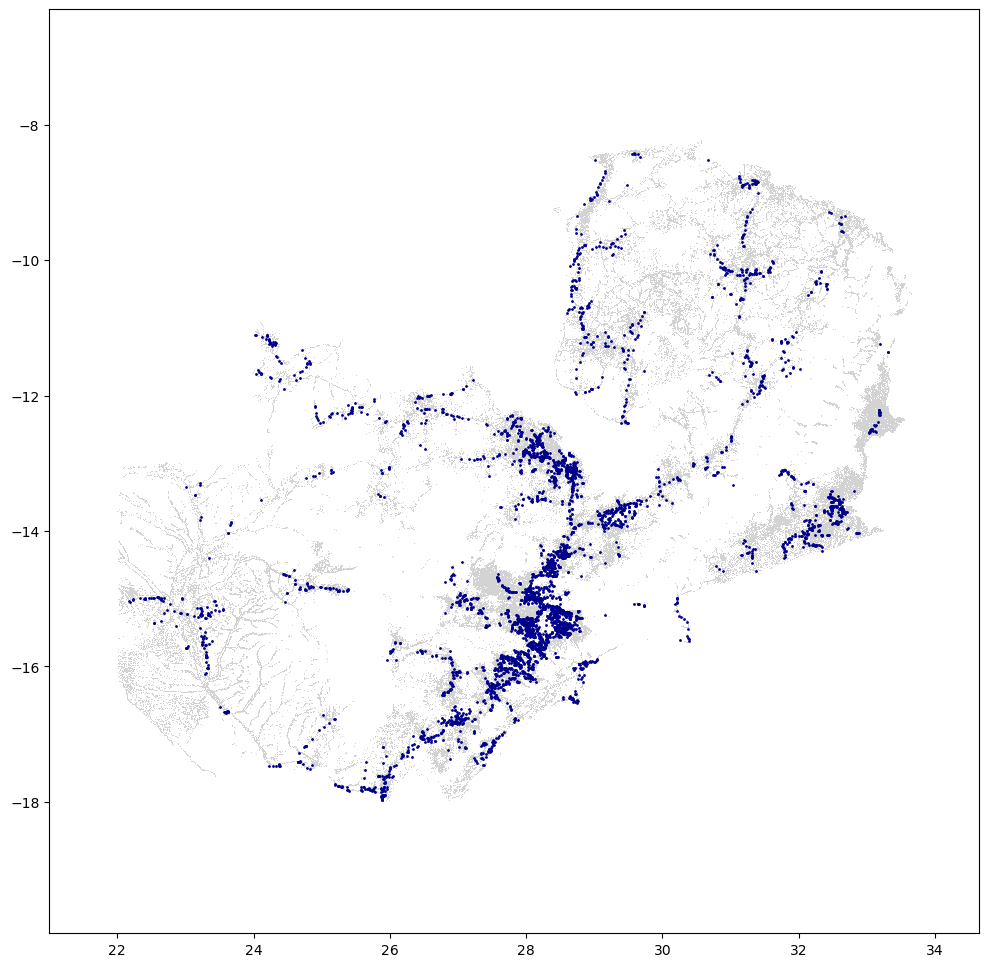

<Figure size 3000x3000 with 0 Axes>

In [17]:
colors = ['#D3D3D3','#808080', 'red']
plt.figure(figsize=(12,12))
plt.plot(onsseter.df.loc[onsseter.df['FinalElecCode' + '{}'.format(start_year)]==99, SET_X_DEG], onsseter.df.loc[onsseter.df['FinalElecCode' + '{}'.format(start_year)]==99, SET_Y_DEG], color='#D3D3D3', marker=',', linestyle='none')
plt.plot(onsseter.df.loc[onsseter.df['FinalElecCode' + '{}'.format(start_year)]==1, SET_X_DEG], onsseter.df.loc[onsseter.df['FinalElecCode' + '{}'.format(start_year)]==1, SET_Y_DEG], color='#00008B', marker='o', ms=1, linestyle='none')
plt.plot(onsseter.df.loc[onsseter.df['FinalElecCode' + '{}'.format(start_year)]==5, SET_X_DEG], onsseter.df.loc[onsseter.df['FinalElecCode' + '{}'.format(start_year)]==5, SET_Y_DEG], color='red', marker='o', ms=2, linestyle='none')
if onsseter.df[SET_X_DEG].max() - onsseter.df[SET_X_DEG].min() > onsseter.df[SET_Y_DEG].max() - onsseter.df[SET_Y_DEG].min():
    plt.xlim(onsseter.df[SET_X_DEG].min() - 1, onsseter.df[SET_X_DEG].max() + 1)
    plt.ylim((onsseter.df[SET_Y_DEG].min()+onsseter.df[SET_Y_DEG].max())/2 - 0.5*abs(onsseter.df[SET_X_DEG].max() - onsseter.df[SET_X_DEG].min()) - 1, (onsseter.df[SET_Y_DEG].min()+onsseter.df[SET_Y_DEG].max())/2 + 0.5*abs(onsseter.df[SET_X_DEG].max() - onsseter.df[SET_X_DEG].min()) + 1)
else:
    plt.xlim((onsseter.df[SET_X_DEG].min()+onsseter.df[SET_X_DEG].max())/2 - 0.5*abs(onsseter.df[SET_Y_DEG].max() - onsseter.df[SET_Y_DEG].min()) - 1, (onsseter.df[SET_X_DEG].min()+onsseter.df[SET_X_DEG].max())/2 + 0.5*abs(onsseter.df[SET_Y_DEG].max() - onsseter.df[SET_Y_DEG].min()) + 1)
    plt.ylim(onsseter.df[SET_Y_DEG].min() -1, onsseter.df[SET_Y_DEG].max() +1)
plt.figure(figsize=(30,30))
logging.getLogger('matplotlib.font_manager').disabled = True
plt.show()

onsseter.df['Technology{}'.format(start_year)] = 'Unelectrified'
onsseter.df.loc[onsseter.df[SET_ELEC_FINAL_CODE + "{}".format(start_year)] == 1, 'Technology{}'.format(start_year)] = 'Existing grid'
onsseter.df.loc[onsseter.df[SET_ELEC_FINAL_CODE + "{}".format(start_year)] == 2, 'Technology{}'.format(start_year)] = 'Grid extension'
onsseter.df.loc[onsseter.df[SET_ELEC_FINAL_CODE + "{}".format(start_year)] == 3, 'Technology{}'.format(start_year)] = 'SHS'
onsseter.df.loc[onsseter.df[SET_ELEC_FINAL_CODE + "{}".format(start_year)] == 5, 'Technology{}'.format(start_year)] = 'PV Hybrid Mini-Grid'
onsseter.df.loc[onsseter.df[SET_ELEC_FINAL_CODE + "{}".format(start_year)] == 6, 'Technology{}'.format(start_year)] = 'Wind Hybrid Mini-Grid'
onsseter.df.loc[onsseter.df[SET_ELEC_FINAL_CODE + "{}".format(start_year)] == 7, 'Technology{}'.format(start_year)] = 'Hydro Mini-Grid'

## 5. Exporting calibrated file

This code saves the calibrated file, which will be used to run scenarios in the next step.

**Note that if you do not change the scenario name, the previous output files will be overwritten**

In [18]:
file_name = "OnSSET_InputFile_Calibrated"

In [19]:
messagebox.showinfo('OnSSET', 'Browse to the folder where you want to save the outputs')

output_dir = filedialog.askdirectory()
output_dir_results = os.path.join(output_dir, '{}.csv'.format(file_name))
onsseter.df.to_csv(output_dir_results, index=False)